# Final Project: Multivariate pattern generator and analyzer

## Problem statement:
The aim of this project is to simulate multivariate response patterns
according to a pre-specified covariance matrix $\Sigma$, and graphically represent 
the similarity relationships of the generated patterns according 
to a number of measures of pattern similarity.

1) A first goal is to 
demonstrate that similarity matrices that are highly similar with respect to
the rank-ordering of their entries can radically differ with regards to the
the nature of the model used to generate the data. In other words, the aim is to show that naively focusing
on the rank-ordering of the cells of similarity matrices can lead to erroneous 
conclusions regarding the underlying generating process.

2) A second goal is 
to aid intuition when it comes to interpret the outcome of multivariate pattern analyses. This is done by
facilitating the graphical exploration of analysis results for parameter combinations flexibly specified by the user.

In [ ]:
# Specify working directory
# cd /Users/fernandoramirez

In [1]:
pwd

'/Users/fernandoramirez/Documents/GitHub/final-project'

In [37]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle 

# Set flags
flag2save = 1 # 1 if generated data is to be saved, otherwise 0 
flag2load = 1 # 1 if data is to be loaded instead of generated, otherwise 0 

# Specify name2save
name2save = 'simul_data_test.pkl'

# Specify name2load
name2load = 'simul_data_test.pkl'

# Initialize the random number generator from platform-dependent source of entropy
np.random.seed(None)

# Get state used as seed in random number generator
rngs = np.random.get_state()

## Define parameters of model used to generate data

In [38]:
# Parameters for both simulations below: 1) monotonic & 2) mirror-symmetric codes
n_ch = 1000 # Number of simulated measurement channels
sf = 1 # Scaling factor. Scales entries in SIGMA.

### A) Monotonic code

In [39]:
# Vector of means, one entry per experimental condition
# v_mean = [0, 0, 0, 0, 0]
v_mean = [0, 0.5, 1, 1.5, 2]
# v_mean = [0, 1, 2, 1, 0]
# v_mean = [2, 1, 0, 1, 2] 

# Vector specifying gain of patterns associated with each condition
vxgain = [1, 1, 1, 1, 1]
# vxgain = [1, 2.2, 3, 2.2, 1]
# vxgain = [3, 2, 1, 2, 3]

In [40]:
# Generate patterns according to the theoretical covariance matrix
# SIGMA. Here, SIGMA reflects a monotonic code reflecting the angular 
# disparity between different presentations of a specifc 3D object.

SIGMA = [[1.00, 0.75, 0.50, 0.25, 0.00],
           [0.75, 1.00, 0.75, 0.50, 0.25],
           [0.50, 0.75, 1.00, 0.75, 0.50],
           [0.25, 0.50, 0.75, 1.00, 0.75],
           [0.00, 0.25, 0.50, 0.75, 1.00]
        ]
# Next, scale SIGMA. This will change the strenght of the signal component 
# associated with each pattern vector, as well as change the type of the
# input (a list) into a numpy array

SIGMA = np.multiply(SIGMA,sf)
print(v_mean)
print( )
print(SIGMA)

[0, 0.5, 1, 1.5, 2]

[[1.   0.75 0.5  0.25 0.  ]
 [0.75 1.   0.75 0.5  0.25]
 [0.5  0.75 1.   0.75 0.5 ]
 [0.25 0.5  0.75 1.   0.75]
 [0.   0.25 0.5  0.75 1.  ]]


In [41]:
# Make sure SIGMA, v_mean, and vxgain have the right dimensions (use Booleans)
if len(SIGMA) != len(SIGMA.T) or len(SIGMA) != len(v_mean):
    print('ERROR: dimensions of SIGMA not allowed')
if (len(v_mean) != len(vxgain)) or (len(vxgain) != len(SIGMA)):
    print('ERROR! dimensions of v_mean and/or vxmean do not match the required value, i.e. five')

## Generate multivariate Gaussian distributed random vectors

In [42]:
simul_data = np.random.multivariate_normal(v_mean,SIGMA,n_ch).T
# simul_data = [x1, x2, x3, x4, x5]
# print(len(x1))
# print([x1[0], x2[0], x3[0], x4[0], x5[0]])

# Modulate response patterns for each condition
simul_data[0] = simul_data[0]*vxgain[0]
simul_data[1] = simul_data[1]*vxgain[1]
simul_data[2] = simul_data[2]*vxgain[2]
simul_data[3] = simul_data[3]*vxgain[3]
simul_data[4] = simul_data[4]*vxgain[4]

np.shape(simul_data)

(5, 1000)

In [43]:
if flag2save:
    # Save simuation parameters and generated data.
    with open(name2save, 'wb') as f:
        pickle.dump([rngs, n_ch, v_mean, SIGMA, vxgain, simul_data], f)

In [44]:
print(np.shape(simul_data)) # n_rows, n_cols

(5, 1000)


In [45]:
def exists(var):
     var_exists = var in locals() or var in globals()
     return var_exists

if flag2load:

    del rngs, n_ch, v_mean, SIGMA, vxgain, simul_data # delete parameters and data
    # Check if variabes were deleated

# Check if variables were cleared
print(exists("rngs"))
print(exists("n_ch"))
print(exists("v_mean"))
print(exists("SIGMA"))
print(exists("vxgain"))

False
False
False
False
False


In [46]:
if flag2load:    
    # Getting back the variables (parameters and data)
    with open('simul_data_test.pkl', 'rb') as f:
        rngs, n_ch, v_mean, SIGMA, vxgain, simul_data = pickle.load(f)

print(exists("rngs"))
print(exists("n_ch"))
print(exists("v_mean"))
print(exists("SIGMA"))
print(exists("vxgain"))

True
True
True
True
True


In [76]:
print(np.shape(simul_data)) # (n_rows, n_cols)

(5, 1000)


## Compute similarity and distance matrices

### Define similarity and distance functions

In [77]:
# Compute empirical similarity matrix using the dot product as similarity function
# Iterate over x1, ..., x5 using a nested for loop

def compute_eSM_dot(simul_data):
    """
    Computes empirical similarity (eSM) matrix according to the dot product
    and returns n by n square symmetric matrix of pairwise similarities for all
    pairs of input vectors.
    Receives a matrix as input, were each column is one vector (or pattern)
    """
        
    eSM_dot  = np.zeros([len(simul_data),len(simul_data)])
    for i in range(len(simul_data)):
    
        for j in range(len(simul_data)):
            # compute dot product     
            eSM_dot[i][j] = simul_data[i] @ simul_data[j]
            
    return eSM_dot

In [78]:
# Compute empirial dissimilarity matrix according to the Euclidean metric
# Iterate over x1, ..., x5

def compute_eDSM_euc(simul_data):
    """
    Computes empirical dissimilarity matrix (eDSM) according to the Euclidean metric
    and returns n by n square symmetric matrix of pairwise Euclidean distances for all
    pairs of input vectors.
    Receives a matrix as input, were each column is one vector (or pattern)
    """
    
    eDSM_euc  = np.zeros([len(simul_data),len(simul_data)])
    for i in range(len(simul_data)):
        
        for j in range(len(simul_data)):    
            # compute Euclidean dist
            eDSM_euc[i][j] = np.sqrt(np.sum(np.square(simul_data[i] - simul_data[j]))) 
            
    return eDSM_euc

In [79]:
# Compute empirial dissimilarity matrix according to the Cosine distance: 1 - cos(theta)
# Iterate over x1, ..., x5

def compute_eDSM_cos(simul_data):
    """
    Computes empirical dissimilarity matrix (eDSM) according to the Cosine distance
    and returns n by n square symmetric matrix of pairwise angular distances observed
    between all pairs of input vectors
    Receives a matrix as input, were each column is one vector (or pattern)
    """
    
    eDSM_cos = np.zeros([len(simul_data),len(simul_data)])
    for i in range(len(simul_data)):
        
        for j in range(len(simul_data)):
            # Compute cosine distance
            eDSM_cos[i][j] = 1 - ((simul_data[i] @ simul_data[j]) / 
                                  (np.linalg.norm(simul_data[i]) * np.linalg.norm(simul_data[j]))
                                 ) 
    return eDSM_cos

## Compute and display matrices

In [80]:
eCOV = np.cov(simul_data) # compute pairwise covariances of simulated patterns --> empirical covariance matrix
eSM_corr = np.corrcoef(simul_data) # compute pairwise correlations of simulated patterns --> empirical corr matrix
eSM_dot  = compute_eSM_dot(simul_data)
eDSM_euc = compute_eDSM_euc(simul_data)
eDSM_cos = compute_eDSM_cos(simul_data)

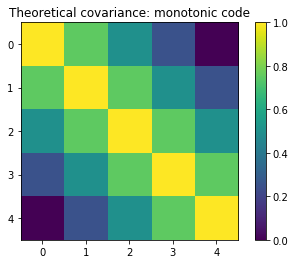

In [81]:
# Plot mat_cov: theoretical covariance structure underlying the generation of the data
plt.imshow(mat_cov)
plt.colorbar()
plt.title('Theoretical covariance: monotonic code')
# plt.axis('off')
plt.show()

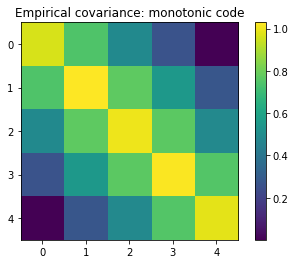

In [82]:
# Plot eCOV: empirically observed covariance structure of simulated data
plt.imshow(eCOV)
plt.colorbar()
plt.title('Empirical covariance: monotonic code')
# plt.axis('off')
plt.show()

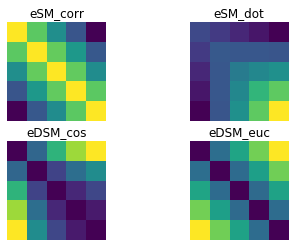

In [83]:
# Show results 
fig, axs = plt.subplots(2,2)
# fig.suptitle('Empirical Matrices')

axs[0, 0].imshow(eSM_corr)
axs[0, 0].set_title('eSM_corr')
axs[0, 0].axis('off')

axs[0, 1].imshow(eSM_dot)
axs[0, 1].set_title('eSM_dot')
axs[0, 1].axis('off')

axs[1, 0].imshow(eDSM_cos)
axs[1, 0].set_title('eDSM_cos')
axs[1, 0].axis('off')

axs[1, 1].imshow(eDSM_euc)
axs[1, 1].set_title('eDSM_euc')
axs[1, 1].axis('off')

fig.savefig('plot_mc.png')

## Define parameters of model used to generate data

### B) Mirror-symmetric code

In [84]:
# Generate patterns conforming to covariance structure SIGMA --> mirror-symmetric
# Note that v_mean and vxgain are inherited from definitions for simulation A) and 
# the patterns generated there are reused here.

data_tau  = np.zeros([len(simul_data), n_ch])

# Preserve cov, but allow different means across mirror-symmetric counterparts
data_tau[0] = simul_data[0]
data_tau[1] = simul_data[1]
data_tau[2] = simul_data[2]
data_tau[3] = simul_data[1]+(v_mean[3]-v_mean[1])
data_tau[4] = simul_data[0]+(v_mean[4]-v_mean[0])

data_tau[0] = data_tau[0]*vxgain[0]
data_tau[1] = data_tau[1]*vxgain[1]
data_tau[2] = data_tau[2]*vxgain[2]
data_tau[3] = data_tau[3]*vxgain[3]
data_tau[4] = data_tau[4]*vxgain[4]

print(np.shape(data_tau)) # n_rows, n_cols

(5, 1000)


In [85]:
eCOV     = np.cov(data_tau) # compute pairwise covariances of simulated patterns
eSM_corr = np.corrcoef(data_tau) # compute pairwise correlations of simulated patterns
eSM_dot  = compute_eSM_dot(data_tau) # eSM_dot
eDSM_euc = compute_eDSM_euc(data_tau) # eDSM_euc
eDSM_cos = compute_eDSM_cos(data_tau) # eDSM_cos

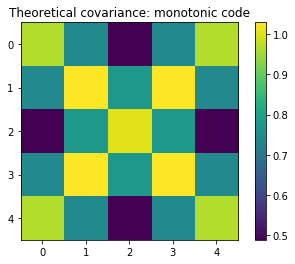

In [86]:
# Plot mat_cov: theoretical covariance structure underlying the generation of the data
plt.imshow(eCOV)
plt.colorbar()
plt.title('Theoretical covariance: monotonic code')
# plt.axis('off')
plt.show()

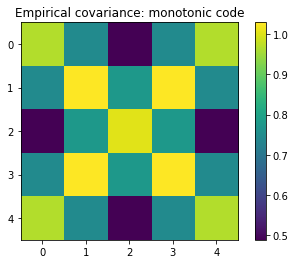

In [87]:
# Plot eCOV: empirically observed covariance structure of simulated data
plt.imshow(eCOV)
plt.colorbar()
plt.title('Empirical covariance: monotonic code')
# plt.axis('off')
plt.show()

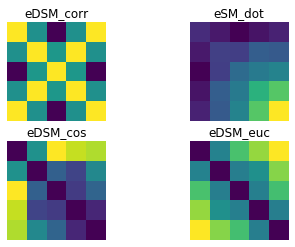

In [88]:
# Subplot showing all metrics, together
fig, axs = plt.subplots(2,2)
# fig.suptitle('Empirical Matrices')

axs[0, 0].imshow(eSM_corr)
axs[0, 0].set_title('eDSM_corr')
axs[0, 0].axis('off')

axs[0, 1].imshow(eSM_dot)
axs[0, 1].set_title('eSM_dot')
axs[0, 1].axis('off')

axs[1, 0].imshow(eDSM_cos)
axs[1, 0].set_title('eDSM_cos')
axs[1, 0].axis('off')

axs[1, 1].imshow(eDSM_euc)
axs[1, 1].set_title('eDSM_euc')
axs[1, 1].axis('off')

fig.savefig('plot_ms.png')

In [ ]:
# Next steps:
# Add structured noise [P]
# Implement data demeaning [P]